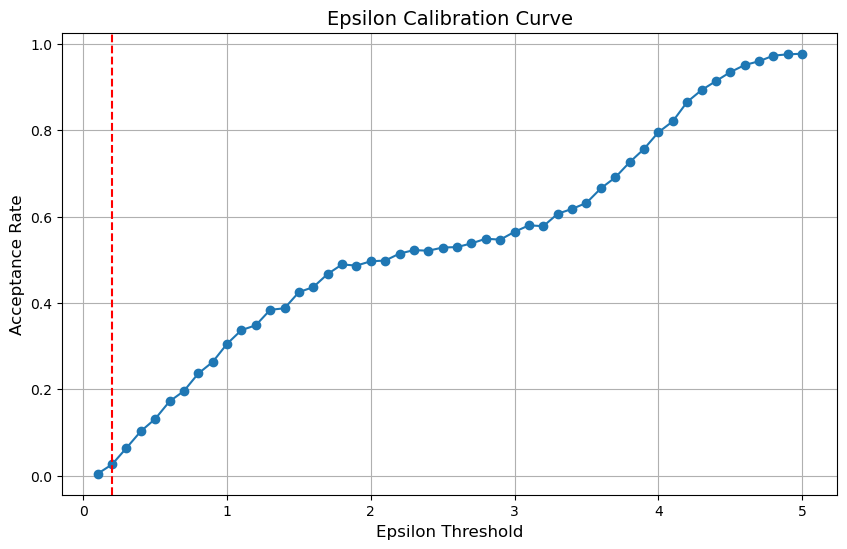

Calibrated epsilon: 0.2000

Model Performance Summary:
- Quadratic: RMSE = 0.0282 (Weight = 0.336) | Accepted Samples = 124
- Exponential: RMSE = 0.0328 (Weight = 0.333) | Accepted Samples = 16
- Hyperbolic: RMSE = nan (Weight = 0.000) | Accepted Samples = 0
- Logarithmic: RMSE = nan (Weight = 0.000) | Accepted Samples = 0
- Cubic: RMSE = 0.0310 (Weight = 0.331) | Accepted Samples = 78

Weighted Ensemble RMSE: 0.0225
Predicted Best Model: Quadratic
Actual Best Model: Quadratic


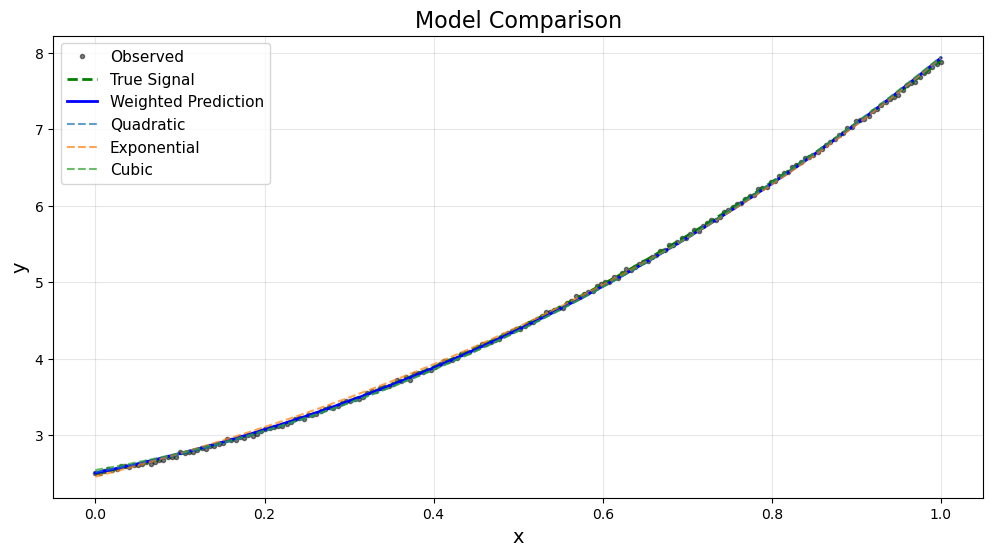


Quadratic Model Posterior Summary:
  θ1: mean=2.489, median=2.477, 95% CI=(2.184, 2.840)
  θ2: mean=2.229, median=2.333, 95% CI=(1.268, 2.964)
  θ3: mean=3.163, median=3.240, 95% CI=(2.214, 3.945)


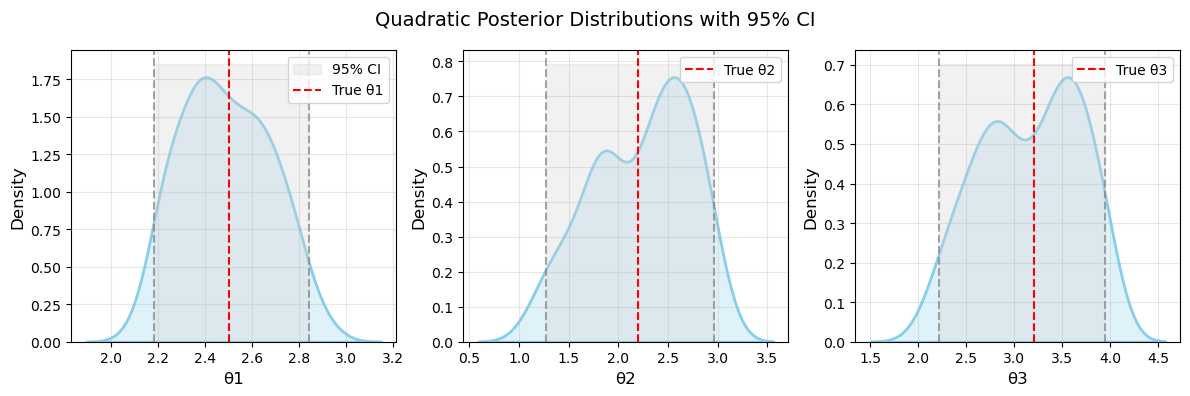

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Exponential Model Posterior Summary:
  θ1: mean=2.395, median=2.386, 95% CI=(2.203, 2.633)
  θ2: mean=1.203, median=1.218, 95% CI=(1.049, 1.325)


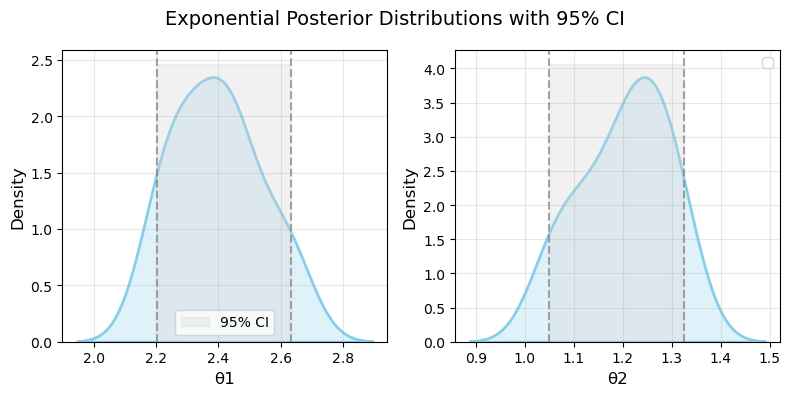

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No accepted samples for Hyperbolic
No accepted samples for Logarithmic

Cubic Model Posterior Summary:
  θ1: mean=2.555, median=2.565, 95% CI=(2.194, 2.903)
  θ2: mean=2.087, median=2.044, 95% CI=(1.202, 2.898)
  θ3: mean=2.988, median=2.974, 95% CI=(2.024, 3.900)
  θ4: mean=0.374, median=0.434, 95% CI=(-1.021, 1.734)


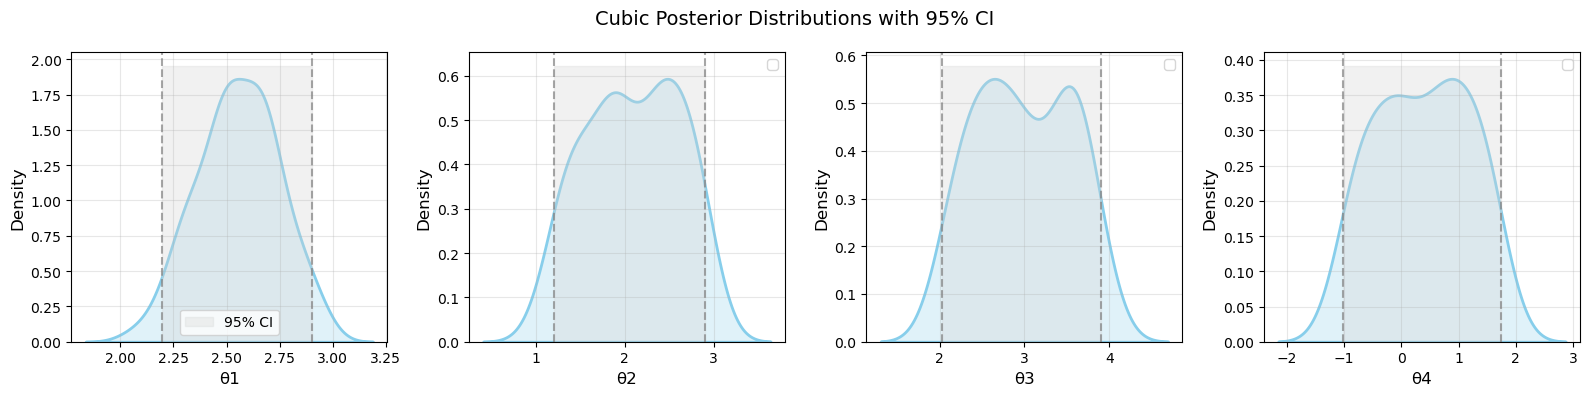

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

np.random.seed(42)
true_coeffs = [2.5, 2.2, 3.2]
n = 200
x = np.linspace(0, 1, n)

def quadratic(x, coeffs):
    return coeffs[0] + coeffs[1] * x + coeffs[2] * x**2

true_signal = quadratic(x, true_coeffs)
noise = 0.01 * np.std(true_signal) * np.random.randn(n)
y_obs = true_signal + noise

def model_quadratic(x, theta):
    return theta[0] + theta[1] * x + theta[2] * x**2

def model_cubic(x, theta):
    return theta[0] + theta[1] * x + theta[2] * x**2 + theta[3] * x**3

def model_exponential(x, theta):
    a, b = theta
    return a * np.exp(b * x)

def model_hyperbolic(x, theta):
    a, b = theta
    return a / (b * x + 1)

def model_logarithmic(x, theta):
    a, b = theta
    return a * np.log(b * x + 1)

models = {
    1: {"name": "Quadratic", "func": model_quadratic, "dim": 3, "prior": [(1, 3), (1, 3), (2, 4)]},
    2: {"name": "Exponential", "func": model_exponential, "dim": 2, "prior": [(1.0, 3.0), (0.5, 2.5)]},
    3: {"name": "Hyperbolic", "func": model_hyperbolic, "dim": 2, "prior": [(1.0, 3.0), (0.1, 2.0)]},
    4: {"name": "Logarithmic", "func": model_logarithmic, "dim": 2, "prior": [(1.0, 3.0), (0.1, 2.0)]},
    5: {"name": "Cubic", "func": model_cubic, "dim": 4, "prior": [(1, 3), (1, 3), (2, 4), (-2, 2)]}
}

def calibrate_epsilon(y_obs, models, x, n_samples=5000):
    epsilons = np.linspace(0.1, 5, 50)
    acceptance_rates = []
    for eps in epsilons:
        accepted = 0
        for _ in range(n_samples):
            model_id = np.random.choice(list(models.keys()))
            model = models[model_id]
            theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
            y_sim = model["func"](x, theta)
            dist = np.sqrt(mean_squared_error(y_obs, y_sim))
            if dist < eps:
                accepted += 1
        acceptance_rates.append(accepted / n_samples)
    best_idx = np.argmin(np.abs(np.array(acceptance_rates) - 0.025))
    best_eps = epsilons[best_idx]
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, acceptance_rates, marker='o')
    plt.axvline(best_eps, color='r', linestyle='--')
    plt.title("Epsilon Calibration Curve", fontsize=14)
    plt.xlabel("Epsilon Threshold", fontsize=12)
    plt.ylabel("Acceptance Rate", fontsize=12)
    plt.grid()
    plt.show()
    print(f"Calibrated epsilon: {best_eps:.4f}")
    return best_eps

def calculate_weights(perf, temp=0.5):
    scores = {}
    for mid, p in perf.items():
        if p["rmse"]:
            scores[mid] = np.exp(-np.median(p["rmse"]) / temp)
        else:
            scores[mid] = 0
    total = sum(scores.values())
    return {mid: (s / total if total > 0 else 1 / len(models)) for mid, s in scores.items()}

def abc_rjmcmc_adaptive(x, y_obs, models, epsilon, n_iter=5000, explore_frac=0.2):
    model_perf = {k: {"rmse": [], "params": [], "accepted": 0} for k in models}
    n_explore = int(n_iter * explore_frac)
    for i in range(n_iter):
        if i < n_explore:
            model_id = np.random.choice(list(models.keys()))
        else:
            weights = calculate_weights(model_perf)
            model_id = np.random.choice(list(weights.keys()), p=list(weights.values()))
        model = models[model_id]
        theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
        y_sim = model["func"](x, theta)
        dist = np.sqrt(mean_squared_error(y_obs, y_sim))
        if dist < epsilon:
            model_perf[model_id]["rmse"].append(dist)
            model_perf[model_id]["params"].append(theta)
            model_perf[model_id]["accepted"] += 1
    return model_perf

epsilon = calibrate_epsilon(y_obs, models, x)
model_performance = abc_rjmcmc_adaptive(x, y_obs, models, epsilon)

weights = calculate_weights(model_performance)
weighted_prediction = np.zeros_like(y_obs)
model_rmse = {}

for mid, perf in model_performance.items():
    name = models[mid]["name"]
    if not perf["params"]:
        model_rmse[name] = np.nan
        continue
    best_idx = np.argmin(perf["rmse"])
    best_theta = perf["params"][best_idx]
    pred = models[mid]["func"](x, best_theta)
    rmse = np.sqrt(mean_squared_error(y_obs, pred))
    model_rmse[name] = rmse
    weighted_prediction += weights[mid] * pred

weighted_rmse = np.sqrt(mean_squared_error(y_obs, weighted_prediction))
predicted_best = models[max(weights, key=weights.get)]["name"]
actual_best = min(model_rmse, key=lambda k: model_rmse[k] if not np.isnan(model_rmse[k]) else np.inf)

print("\nModel Performance Summary:")
for m, rmse in model_rmse.items():
    model_id = next((mid for mid, model in models.items() if model["name"] == m), None)
    weight = weights.get(model_id, 0) if model_id is not None else 0
    accepted = model_performance[model_id]["accepted"]
    print(f"- {m}: RMSE = {rmse:.4f} (Weight = {weight:.3f}) | Accepted Samples = {accepted}")

print(f"\nWeighted Ensemble RMSE: {weighted_rmse:.4f}")
print(f"Predicted Best Model: {predicted_best}")
print(f"Actual Best Model: {actual_best}")

plt.figure(figsize=(12, 6))
plt.plot(x, y_obs, 'k.', alpha=0.5, label="Observed")
plt.plot(x, true_signal, 'g--', linewidth=2, label="True Signal")
plt.plot(x, weighted_prediction, 'b-', linewidth=2, label="Weighted Prediction")
for mid, perf in model_performance.items():
    if perf["params"]:
        best_theta = perf["params"][np.argmin(perf["rmse"])]
        plt.plot(x, models[mid]["func"](x, best_theta), '--', alpha=0.7, label=models[mid]["name"])
plt.title("Model Comparison", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.show()

def plot_all_model_posteriors(perf, models, true_coeffs=None):
    for mid, model in models.items():
        model_name = model["name"]
        params = np.array(perf[mid]["params"])
        if params.size == 0:
            print(f"No accepted samples for {model_name}")
            continue
        print(f"\n{model_name} Model Posterior Summary:")
        for i in range(model["dim"]):
            mean_val = np.mean(params[:, i])
            median_val = np.median(params[:, i])
            ci_lower, ci_upper = np.percentile(params[:, i], [2.5, 97.5])
            print(f"  θ{i+1}: mean={mean_val:.3f}, median={median_val:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})")
        plt.figure(figsize=(4 * model["dim"], 4))
        for i in range(model["dim"]):
            plt.subplot(1, model["dim"], i + 1)
            sns.kdeplot(params[:, i], fill=True, color='skyblue', lw=2)
            ci_lower, ci_upper = np.percentile(params[:, i], [2.5, 97.5])
            plt.axvline(ci_lower, color='gray', linestyle='--', alpha=0.7)
            plt.axvline(ci_upper, color='gray', linestyle='--', alpha=0.7)
            plt.fill_betweenx(
                y=np.linspace(0, plt.gca().get_ylim()[1], 100),
                x1=ci_lower, x2=ci_upper, color='lightgray', alpha=0.3,
                label="95% CI" if i == 0 else None
            )
            if true_coeffs is not None and mid == 1 and i < len(true_coeffs):
                plt.axvline(true_coeffs[i], color='red', linestyle='--', label=f"True θ{i+1}")
            plt.xlabel(f"θ{i+1}", fontsize=12)
            plt.ylabel("Density", fontsize=12)
            plt.legend(fontsize=10)
            plt.grid(alpha=0.3)
        plt.suptitle(f"{model_name} Posterior Distributions with 95% CI", fontsize=14)
        plt.tight_layout()
        plt.show()

plot_all_model_posteriors(model_performance, models, true_coeffs=true_coeffs)


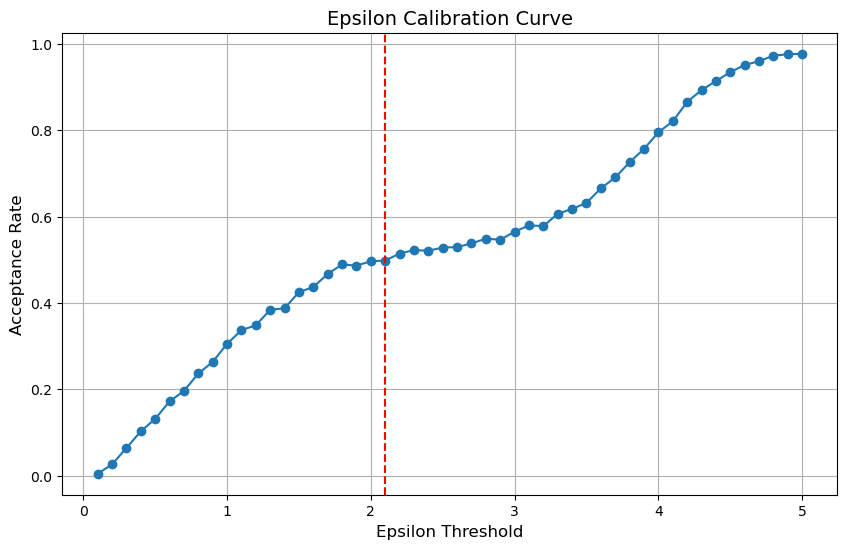

Calibrated epsilon: 2.1000

Model Performance Summary:
- Quadratic: RMSE = 0.0282 (Weight = 0.444) | Accepted Samples = 1912
- Exponential: RMSE = 0.0895 (Weight = 0.181) | Accepted Samples = 510
- Hyperbolic: RMSE = nan (Weight = 0.000) | Accepted Samples = 0
- Logarithmic: RMSE = nan (Weight = 0.000) | Accepted Samples = 0
- Cubic: RMSE = 0.0548 (Weight = 0.375) | Accepted Samples = 1669

Weighted Ensemble RMSE: 0.0233
Predicted Best Model: Quadratic
Actual Best Model: Quadratic


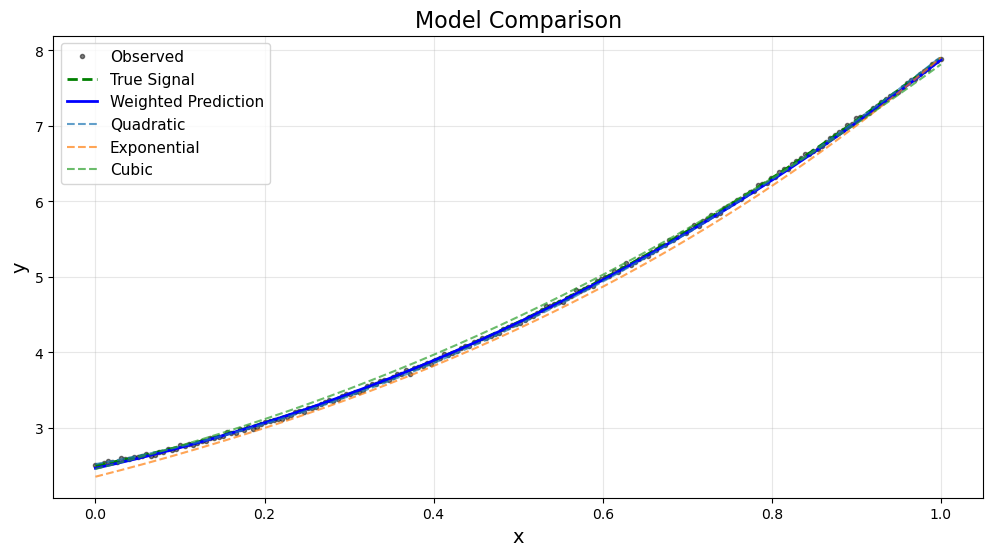


Quadratic Model Posterior Summary:
  θ1: mean=2.019, median=2.032, 95% CI=(1.051, 2.950)
  θ2: mean=1.991, median=1.987, 95% CI=(1.050, 2.959)
  θ3: mean=3.023, median=3.017, 95% CI=(2.066, 3.952)


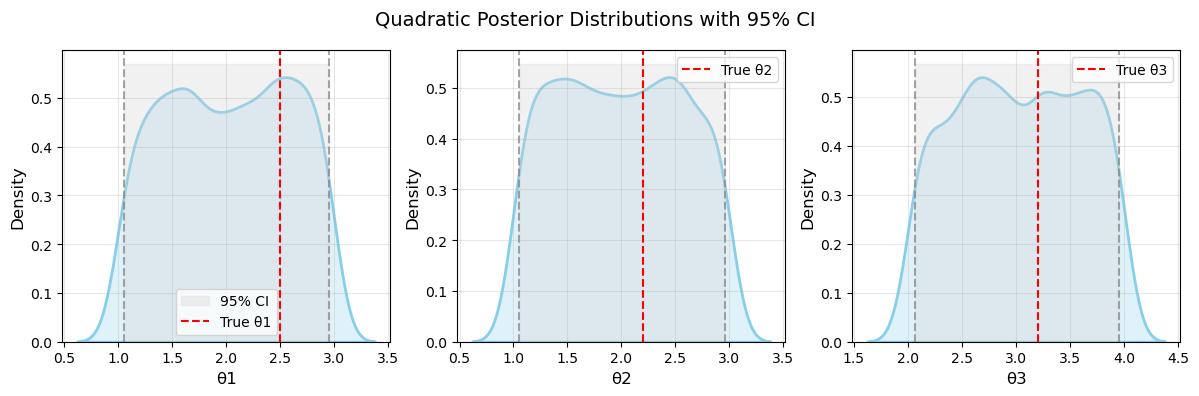

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Exponential Model Posterior Summary:
  θ1: mean=1.993, median=2.018, 95% CI=(1.044, 2.918)
  θ2: mean=1.373, median=1.361, 95% CI=(0.587, 2.331)


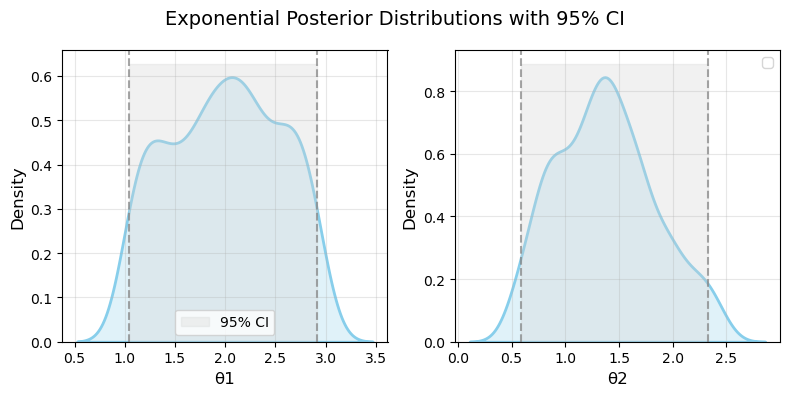

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No accepted samples for Hyperbolic
No accepted samples for Logarithmic

Cubic Model Posterior Summary:
  θ1: mean=2.024, median=2.010, 95% CI=(1.070, 2.955)
  θ2: mean=2.023, median=2.005, 95% CI=(1.072, 2.955)
  θ3: mean=3.027, median=3.056, 95% CI=(2.061, 3.950)
  θ4: mean=0.030, median=0.064, 95% CI=(-1.896, 1.880)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


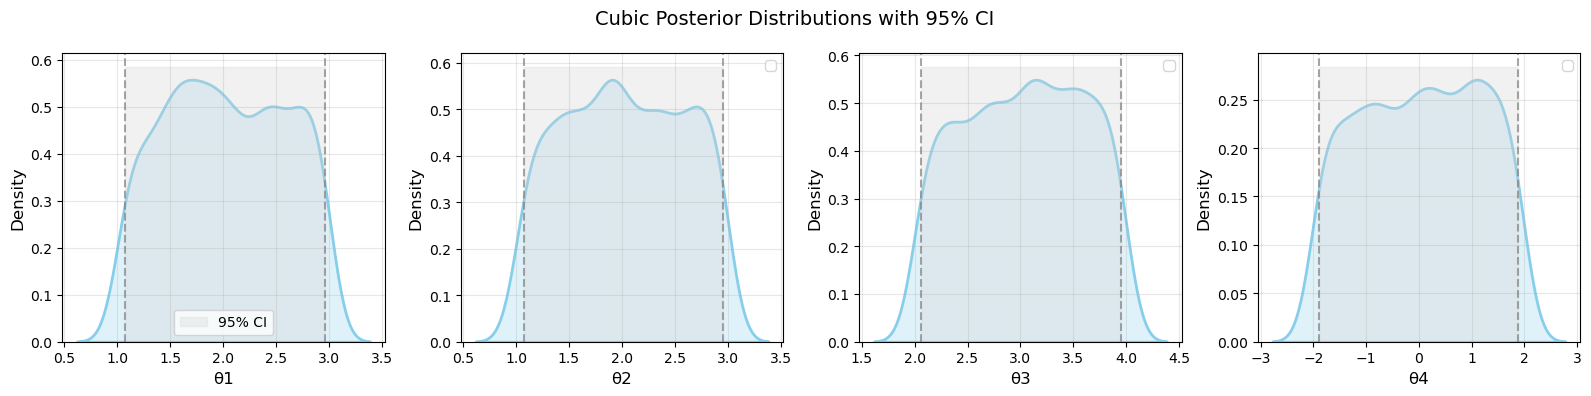

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

np.random.seed(42)
true_coeffs = [2.5, 2.2, 3.2]
n = 200
x = np.linspace(0, 1, n)

def quadratic(x, coeffs):
    return coeffs[0] + coeffs[1] * x + coeffs[2] * x**2

true_signal = quadratic(x, true_coeffs)
noise = 0.01 * np.std(true_signal) * np.random.randn(n)
y_obs = true_signal + noise

def model_quadratic(x, theta):
    return theta[0] + theta[1] * x + theta[2] * x**2

def model_cubic(x, theta):
    return theta[0] + theta[1] * x + theta[2] * x**2 + theta[3] * x**3

def model_exponential(x, theta):
    a, b = theta
    return a * np.exp(b * x)

def model_hyperbolic(x, theta):
    a, b = theta
    return a / (b * x + 1)

def model_logarithmic(x, theta):
    a, b = theta
    return a * np.log(b * x + 1)

models = {
    1: {"name": "Quadratic", "func": model_quadratic, "dim": 3, "prior": [(1, 3), (1, 3), (2, 4)]},
    2: {"name": "Exponential", "func": model_exponential, "dim": 2, "prior": [(1.0, 3.0), (0.5, 2.5)]},
    3: {"name": "Hyperbolic", "func": model_hyperbolic, "dim": 2, "prior": [(1.0, 3.0), (0.1, 2.0)]},
    4: {"name": "Logarithmic", "func": model_logarithmic, "dim": 2, "prior": [(1.0, 3.0), (0.1, 2.0)]},
    5: {"name": "Cubic", "func": model_cubic, "dim": 4, "prior": [(1, 3), (1, 3), (2, 4), (-2, 2)]}
}

def calibrate_epsilon(y_obs, models, x, n_samples=5000):
    epsilons = np.linspace(0.1, 5, 50)
    acceptance_rates = []
    for eps in epsilons:
        accepted = 0
        for _ in range(n_samples):
            model_id = np.random.choice(list(models.keys()))
            model = models[model_id]
            theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
            y_sim = model["func"](x, theta)
            dist = np.sqrt(mean_squared_error(y_obs, y_sim))
            if dist < eps:
                accepted += 1
        acceptance_rates.append(accepted / n_samples)
    best_idx = np.argmin(np.abs(np.array(acceptance_rates) - 0.5))
    best_eps = epsilons[best_idx]
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, acceptance_rates, marker='o')
    plt.axvline(best_eps, color='r', linestyle='--')
    plt.title("Epsilon Calibration Curve", fontsize=14)
    plt.xlabel("Epsilon Threshold", fontsize=12)
    plt.ylabel("Acceptance Rate", fontsize=12)
    plt.grid()
    plt.show()
    print(f"Calibrated epsilon: {best_eps:.4f}")
    return best_eps

def calculate_weights(perf, temp=0.5):
    scores = {}
    for mid, p in perf.items():
        if p["rmse"]:
            scores[mid] = np.exp(-np.median(p["rmse"]) / temp)
        else:
            scores[mid] = 0
    total = sum(scores.values())
    return {mid: (s / total if total > 0 else 1 / len(models)) for mid, s in scores.items()}

def abc_rjmcmc_adaptive(x, y_obs, models, epsilon, n_iter=5000, explore_frac=0.2):
    model_perf = {k: {"rmse": [], "params": [], "accepted": 0} for k in models}
    n_explore = int(n_iter * explore_frac)
    for i in range(n_iter):
        if i < n_explore:
            model_id = np.random.choice(list(models.keys()))
        else:
            weights = calculate_weights(model_perf)
            model_id = np.random.choice(list(weights.keys()), p=list(weights.values()))
        model = models[model_id]
        theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
        y_sim = model["func"](x, theta)
        dist = np.sqrt(mean_squared_error(y_obs, y_sim))
        if dist < epsilon:
            model_perf[model_id]["rmse"].append(dist)
            model_perf[model_id]["params"].append(theta)
            model_perf[model_id]["accepted"] += 1
    return model_perf

epsilon = calibrate_epsilon(y_obs, models, x)
model_performance = abc_rjmcmc_adaptive(x, y_obs, models, epsilon)

weights = calculate_weights(model_performance)
weighted_prediction = np.zeros_like(y_obs)
model_rmse = {}

for mid, perf in model_performance.items():
    name = models[mid]["name"]
    if not perf["params"]:
        model_rmse[name] = np.nan
        continue
    best_idx = np.argmin(perf["rmse"])
    best_theta = perf["params"][best_idx]
    pred = models[mid]["func"](x, best_theta)
    rmse = np.sqrt(mean_squared_error(y_obs, pred))
    model_rmse[name] = rmse
    weighted_prediction += weights[mid] * pred

weighted_rmse = np.sqrt(mean_squared_error(y_obs, weighted_prediction))
predicted_best = models[max(weights, key=weights.get)]["name"]
actual_best = min(model_rmse, key=lambda k: model_rmse[k] if not np.isnan(model_rmse[k]) else np.inf)

print("\nModel Performance Summary:")
for m, rmse in model_rmse.items():
    model_id = next((mid for mid, model in models.items() if model["name"] == m), None)
    weight = weights.get(model_id, 0) if model_id is not None else 0
    accepted = model_performance[model_id]["accepted"]
    print(f"- {m}: RMSE = {rmse:.4f} (Weight = {weight:.3f}) | Accepted Samples = {accepted}")

print(f"\nWeighted Ensemble RMSE: {weighted_rmse:.4f}")
print(f"Predicted Best Model: {predicted_best}")
print(f"Actual Best Model: {actual_best}")

plt.figure(figsize=(12, 6))
plt.plot(x, y_obs, 'k.', alpha=0.5, label="Observed")
plt.plot(x, true_signal, 'g--', linewidth=2, label="True Signal")
plt.plot(x, weighted_prediction, 'b-', linewidth=2, label="Weighted Prediction")
for mid, perf in model_performance.items():
    if perf["params"]:
        best_theta = perf["params"][np.argmin(perf["rmse"])]
        plt.plot(x, models[mid]["func"](x, best_theta), '--', alpha=0.7, label=models[mid]["name"])
plt.title("Model Comparison", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.show()

def plot_all_model_posteriors(perf, models, true_coeffs=None):
    for mid, model in models.items():
        model_name = model["name"]
        params = np.array(perf[mid]["params"])
        if params.size == 0:
            print(f"No accepted samples for {model_name}")
            continue
        print(f"\n{model_name} Model Posterior Summary:")
        for i in range(model["dim"]):
            mean_val = np.mean(params[:, i])
            median_val = np.median(params[:, i])
            ci_lower, ci_upper = np.percentile(params[:, i], [2.5, 97.5])
            print(f"  θ{i+1}: mean={mean_val:.3f}, median={median_val:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})")
        plt.figure(figsize=(4 * model["dim"], 4))
        for i in range(model["dim"]):
            plt.subplot(1, model["dim"], i + 1)
            sns.kdeplot(params[:, i], fill=True, color='skyblue', lw=2)
            ci_lower, ci_upper = np.percentile(params[:, i], [2.5, 97.5])
            plt.axvline(ci_lower, color='gray', linestyle='--', alpha=0.7)
            plt.axvline(ci_upper, color='gray', linestyle='--', alpha=0.7)
            plt.fill_betweenx(
                y=np.linspace(0, plt.gca().get_ylim()[1], 100),
                x1=ci_lower, x2=ci_upper, color='lightgray', alpha=0.3,
                label="95% CI" if i == 0 else None
            )
            if true_coeffs is not None and mid == 1 and i < len(true_coeffs):
                plt.axvline(true_coeffs[i], color='red', linestyle='--', label=f"True θ{i+1}")
            plt.xlabel(f"θ{i+1}", fontsize=12)
            plt.ylabel("Density", fontsize=12)
            plt.legend(fontsize=10)
            plt.grid(alpha=0.3)
        plt.suptitle(f"{model_name} Posterior Distributions with 95% CI", fontsize=14)
        plt.tight_layout()
        plt.show()

plot_all_model_posteriors(model_performance, models, true_coeffs=true_coeffs)
